<a href="https://colab.research.google.com/github/krishnakaushik25/DataQuest-Guided-Projects/blob/main/Predicting_Bike_Rental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Predicting Bike Rental
 ![rental.jpeg](attachment:rental.jpeg)
 
 

 
 Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll work with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, Irvine's <a href="https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset" target="_blank">website</a>. 

The goal of this project  - predict dispersion total number of rented bikes by hour using different <a href="https://scikit-learn.org/stable/index.html" target="_blank">scikit-learn</a> regression algorithms.   
 

## 1. Introduction to the Dataset

Load necessary modules and dataset and explore it. 

/home/mvg/ds387/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

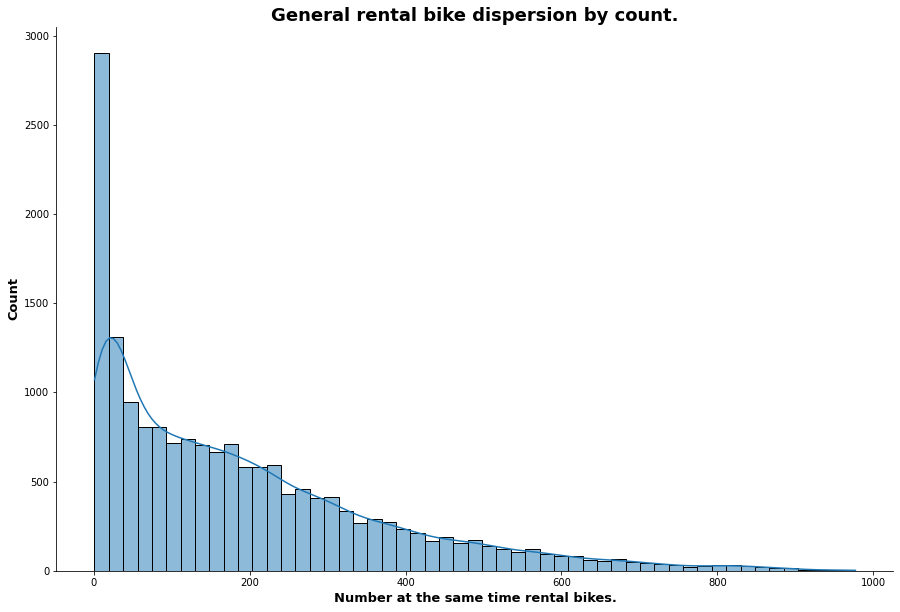

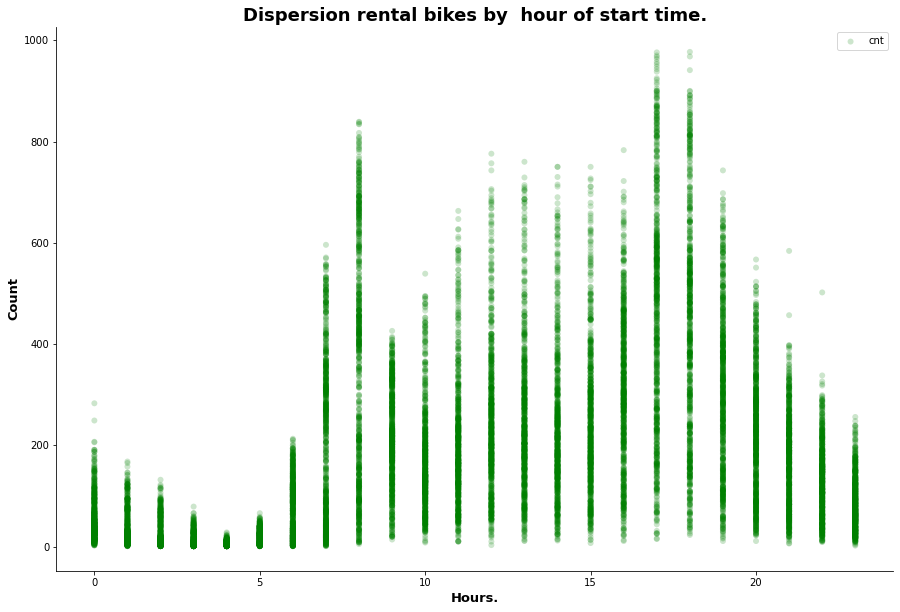

In [ ]:
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
from pprint import pprint
import seaborn as sns
from IPython.display import display
from IPython.display import HTML
from time import time

# algorithms and metrics for ML
from sklearn import linear_model

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

# open
bike_rent_raw = pd.read_csv("data/hour.csv", parse_dates= ["dteday"])

# get info
print(bike_rent_raw.info())

# check NaN values
print(bike_rent_raw.isnull().sum())

# Plot histogram for amount rent
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.histplot(data = bike_rent_raw, x = "cnt", kde = True)
ax.set_title("General rental bike dispersion by count.",
             fontsize = 18, fontweight = "bold")
ax.set_xlabel("Number at the same time rental bikes.", fontsize = 13, 
              fontweight = "bold")
ax.set_ylabel("Count", fontsize = 13, 
              fontweight = "bold")
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.show()


# Plot scatter by hours
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(bike_rent_raw.hr, bike_rent_raw.cnt ,  c='green', label="cnt", 
           alpha=0.2, edgecolors='none')
ax.set_title("Dispersion rental bikes by  hour of start time.",
             fontsize = 18, fontweight = "bold")
ax.set_xlabel("Hours.", fontsize = 13, 
              fontweight = "bold")
ax.set_ylabel("Count", fontsize = 13, 
              fontweight = "bold")
ax.legend()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.show()

## 2.Selecting  Features

In [ ]:
# Define function for check collinearity
def collinearity(data_x_all, features):
    """
    Define variance inflation factor (VIF) for features of predictor with 
    using  different scalers.   Input arguments – df and list of 
    tested features. Return df with VIF values for each futures in 
    the  different scales.
    “As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a 
    problematic amount of  collinearity”.  
    p.110 An Introduction to Statistical Learning with Applications in R 
    © Springer Science+Business Media New York 2013 
    DOI 10.1007/978-1-4614-7138-7

    Parameters
    ----------
    data_x_all : pandas df with raw numerical values without any 
    encoding.
        df X with tested features columns.
    features : list of column names of dataframe
        Features for VIF calculation.
    Returns
    -------
    vif_df : df
        VIF values for feature columns in the different scales.

    """
    test_df = data_x_all.copy()
    test_df = test_df[~test_df.isnull().any(axis =1)]
    test_feat = features[:]
    test_df = test_df[test_feat]
    
    # create empty dataframe for collected data
    vif_df = pd.DataFrame()
    vif_df["feature"] = test_feat
    
    # find vif for non sclaed data
    vif_df["no_scale"] = [variance_inflation_factor(test_df.values, i)
                          for i in range(len(test_feat))]
    
    # find vif for minmax scaler
    min_max = MinMaxScaler()
    test_df_min_max = min_max.fit_transform(test_df.copy())
    vif_df["min_max_scale"] = [variance_inflation_factor(test_df_min_max, i)
                          for i in range(len(test_feat))]
    
    # find vir for robust scaler
    robust = RobustScaler()
    test_df_robust = robust.fit_transform(test_df.copy())
    vif_df["robust_scale"] = [variance_inflation_factor(test_df_robust, i)
                          for i in range(len(test_feat))]
    
    # find vif for standard scaler
    standard = StandardScaler()
    test_df_standard = standard.fit_transform(test_df.copy())
    vif_df["standard_scale"] = [variance_inflation_factor(test_df_standard, i)
                          for i in range(len(test_feat))]
    
    vif_df.sort_values(by = "standard_scale", ascending = False, 
                       inplace = True)
    vif_df.reset_index(drop = True, inplace = True)
    return vif_df


# define first iteration for features for check collinearity and scaler exlude cont columns
feats_test_1 = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
              'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
              'casual', 'registered', ]


feats_colnr_1 = collinearity(bike_rent_raw, feats_test_1)
display(feats_colnr_1)

,feature,no_scale,min_max_scale,robust_scale,standard_scale
0,instant,2049.113625,2222.335573,4.909384,572.102174
1,yr,778.456623,853.339103,4.855148,435.547942
2,mnth,604.307429,512.179614,5.450853,145.817742
3,atemp,362.059196,336.982953,44.225454,44.149548
4,temp,324.600168,285.605283,43.867931,43.901532
5,season,21.328337,9.962479,4.242087,3.528103
6,casual,3.288642,3.276628,2.494149,2.181291
7,registered,3.600776,3.607222,1.900890,1.786188
8,hum,13.966831,11.451874,1.665525,1.667936
9,workingday,4.197015,4.162560,2.054851,1.404410


Our mail goal - predict with maximal accuracy values of  `cnt`. The sum of features  `casual` and 	`registered` equal `cnt`. If now  I don't remove `casual` and `registered`  - I can get R2 = 1.0 using standard linear regression. Make second iteration for features and for next features.

In [ ]:
feats_test_2 = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
              'workingday', 'weathersit', 'temp',  'hum', 'windspeed',
              'casual', 'registered', ]

feats_colnr_2 = collinearity(bike_rent_raw, feats_test_2)
display(feats_colnr_2)

,feature,no_scale,min_max_scale,robust_scale,standard_scale
0,season,21.206015,9.954909,3.755889,3.525045
1,mnth,15.156667,11.628009,3.189366,3.284577
2,casual,3.269718,3.254960,2.489887,2.178816
3,registered,3.598131,3.605772,1.662216,1.785476
4,hum,12.648351,9.244189,1.628955,1.659326
5,temp,10.790105,10.010510,1.491336,1.493336
6,workingday,4.150759,4.113494,1.829427,1.404374
7,weathersit,7.621134,1.757265,1.547947,1.281366
8,hr,4.281648,4.223568,1.204546,1.262326
9,windspeed,3.219399,3.133581,1.123343,1.141063


Define final features and check it

In [ ]:
feats_fin = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
              'workingday', 'weathersit', 'temp',  'hum', 'windspeed', 'cnt']

feats_colnr_fin = collinearity(bike_rent_raw, feats_fin)
display(feats_colnr_fin)

,feature,no_scale,min_max_scale,robust_scale,standard_scale
0,season,21.202729,9.939494,3.751447,3.522232
1,mnth,15.156503,11.625310,3.184287,3.284559
2,cnt,3.414411,3.396512,1.513179,1.633316
3,hum,12.341705,9.057238,1.563811,1.592021
4,temp,9.117986,8.413831,1.311808,1.312557
5,weathersit,7.596711,1.756730,1.540150,1.278404
6,hr,4.270875,4.208415,1.208825,1.262296
7,windspeed,3.214445,3.125841,1.122980,1.140653
8,yr,2.099725,2.101167,1.414819,1.093082
9,holiday,1.096568,1.098385,1.113298,1.081296


## 3.  Data preprocessing 

In [ ]:
# create df for ML
bike_rent = bike_rent_raw[feats_fin].copy() 

# encode dataset with StandardScaler
bike_rent_ss = bike_rent.copy()

ss_x_all = StandardScaler()
ss_y_all = StandardScaler()

bike_rent_ss.iloc[:,:-1] = ss_x_all.fit_transform(bike_rent_ss.iloc[:,:-1])
bike_rent_ss.iloc[:,[-1]] = ss_y_all.fit_transform(bike_rent_ss.iloc[:,[-1]])

## 4. Applying Linear Regression

In [ ]:
# cross validation MAE RMSE and R2
X_ss_all = bike_rent_ss.iloc[:,:-1].copy()
Y_ss_all = bike_rent_ss.iloc[:,[-1]].copy()

# Define cv 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# create model
lr_ols_cv = LinearRegression()

# Collect cv parameters
lr_mae_cv = -cross_val_score(lr_ols_cv, X_ss_all, Y_ss_all, 
                             scoring="neg_mean_absolute_error", 
                             cv=cv, n_jobs=-1)
lr_mae_mean_cv = np.mean(lr_mae_cv)
lr_mae_std_cv = np.std(lr_mae_cv)

lr_rmse_cv = -cross_val_score(lr_ols_cv, X_ss_all, Y_ss_all, 
                              scoring='neg_root_mean_squared_error', 
                              cv=cv, n_jobs=-1)
lr_rmse_mean_cv = np.mean(lr_rmse_cv)


lr_r2_cv = cross_val_score(lr_ols_cv, X_ss_all, Y_ss_all, 
                           scoring='r2', cv=cv, n_jobs=-1)
lr_r2_mean_cv = np.mean(lr_r2_cv)


# Train model 
X_ss, x_ss, Y_ss, y_ss = train_test_split(X_ss_all, Y_ss_all, test_size= 0.2, random_state=42)
lr_ols = LinearRegression()
lr_ols.fit(X_ss, Y_ss)
y_ss_pr = lr_ols.predict(x_ss)
lr_ols_ss_mae = mean_absolute_error(y_ss, y_ss_pr)
lr_ols_ss_rmse = mean_squared_error(y_ss, y_ss_pr, squared=False)
lr_ols_ss_r2 = r2_score(y_ss, y_ss_pr)

# Decode y and y_pred back
y = y_ss.copy()
y.iloc[:,[0]] = ss_y_all.inverse_transform(y.iloc[:,[0]])

y_pr = y_ss_pr.copy()
y_pr = ss_y_all.inverse_transform(y_pr)

# collect metric again
lr_ols_mae = mean_absolute_error(y, y_pr)
lr_ols_rmse = mean_squared_error(y, y_pr, squared=False)
lr_ols_r2 = r2_score(y, y_pr)

# Create metric df for linear regression
lr_metric  = pd.DataFrame()
lr_metric["metrics"] = ["mae", "rmse", "r2"]
lr_metric["ss_cv_values"] = [lr_mae_mean_cv, lr_rmse_mean_cv, lr_rmse_mean_cv ]
lr_metric["ss_values"] = [lr_ols_ss_mae, lr_ols_ss_rmse, lr_ols_ss_r2 ]
lr_metric["real_values"] = [lr_ols_mae, lr_ols_rmse, lr_ols_r2 ]
display(lr_metric)

,metrics,ss_cv_values,ss_values,real_values
0,mae,0.585134,0.578775,104.979543
1,rmse,0.782727,0.768744,139.436655
2,r2,0.782727,0.385999,0.385999


As seen above practical R2 = 0.386 equal one half of cross validation R2 = 0.783. I rounded the values or R2 to three decimal places.

## 5. Apply decision tree

In [ ]:
# Find optimal max_depth

des_tree_met = pd.DataFrame()
des_tree_met["cv_score"] = ["mae_mean", "mae_std", "rmse_mean", "rmse_std",
                            "r2_mean", "r2_std"]
                            

for i in range(2,21):
    tree_reg = DecisionTreeRegressor(max_depth=i) 
    tree_reg.fit(X_ss, Y_ss)
    cv_mae = -cross_val_score(tree_reg, X_ss_all, Y_ss_all, 
                             scoring="neg_mean_absolute_error", 
                             cv=cv, n_jobs=4)
    cv_mae_mean = np.mean(cv_mae)
    cv_mae_std = np.std(cv_mae)

    cv_rmse = -cross_val_score(tree_reg, X_ss_all, Y_ss_all, 
                              scoring='neg_root_mean_squared_error', 
                              cv=cv, n_jobs=4)
    cv_rmse_mean = np.mean(cv_rmse)
    cv_rmse_std = np.std(cv_rmse)

    cv_r2 = cross_val_score(tree_reg, X_ss_all, Y_ss_all, 
                           scoring='r2', cv=cv, n_jobs=4)
    cv_r2_mean = np.mean(cv_r2)
    cv_r2_std = np.std(cv_r2)
    des_tree_met[str(i)] = [cv_mae_mean, cv_mae_std, cv_rmse_mean, cv_rmse_std,
                            cv_r2_mean, cv_r2_std] 

display(des_tree_met)

,cv_score,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,mae_mean,0.536973,0.496779,0.448315,0.393702,0.358217,0.293864,0.257646,0.223920,0.199082,0.186672,0.181088,0.179150,0.179241,0.181054,0.182988,0.184353,0.185086,0.185944,0.187312
1,mae_std,0.014067,0.013307,0.010649,0.009408,0.008657,0.008116,0.007604,0.006738,0.005977,0.006438,0.006559,0.007329,0.007231,0.007181,0.007112,0.006940,0.007202,0.007828,0.007534
2,rmse_mean,0.767669,0.712444,0.656529,0.594434,0.556519,0.461567,0.410370,0.357924,0.326615,0.314113,0.312174,0.309861,0.312197,0.314888,0.319875,0.320428,0.321953,0.324491,0.323566
3,rmse_std,0.018742,0.016575,0.014849,0.012691,0.012050,0.014911,0.015344,0.012386,0.011695,0.015499,0.017622,0.019874,0.019732,0.017091,0.019138,0.017805,0.020298,0.019301,0.019409
4,r2_mean,0.410165,0.491916,0.568494,0.646154,0.689891,0.786569,0.831182,0.871825,0.892963,0.901408,0.902720,0.904482,0.902327,0.900045,0.897867,0.896905,0.895957,0.895783,0.894260
5,r2_std,0.013367,0.012920,0.012244,0.012754,0.010164,0.012193,0.012353,0.008106,0.007969,0.009349,0.011906,0.012110,0.012400,0.012377,0.013106,0.011799,0.013237,0.012321,0.013323


Test under and over fitting

In [ ]:
# Create df with metric
des_tree_fitt = pd.DataFrame()
des_tree_fitt["scores"] = ["mae", "rmse", "r2"]

# Fill df
for i in range(2,21):
    tree_reg = DecisionTreeRegressor(max_depth=i) 
    X_ss, x_ss, Y_ss, y_ss = train_test_split(X_ss_all, Y_ss_all, 
                                              test_size= 0.3, random_state=42)
    tree_reg.fit(X_ss, Y_ss)
    # Calculate scoring for predict x
    y_ss_pr =tree_reg.predict(x_ss) 
    mae_pr = mean_absolute_error(y_ss, y_ss_pr)
    rmse_pr = mean_squared_error(y_ss, y_ss_pr, squared=False)
    r2_pr = r2_score(y_ss, y_ss_pr)
    pred_col_name = "y_pred_dp_" + str(i)
    des_tree_fitt[pred_col_name] = [mae_pr, rmse_pr, r2_pr]
    # Calculate scoring for predict  X 
    Y_ss_pr =tree_reg.predict(X_ss)
    mae_pr_Y = mean_absolute_error(Y_ss, Y_ss_pr)
    rmse_pr_Y = mean_squared_error(Y_ss, Y_ss_pr, squared=False)
    r2_pr_Y = r2_score(Y_ss, Y_ss_pr)
    pred_col_name_Y = "Y_pred_dp_" + str(i)
    des_tree_fitt[pred_col_name_Y] = [mae_pr_Y, rmse_pr_Y, r2_pr_Y]
    dif_name = "diff_y-Y " + str(i)
    des_tree_fitt[dif_name] = des_tree_fitt[pred_col_name]  \
                            - des_tree_fitt[pred_col_name_Y]
    
display(des_tree_fitt.iloc[:, :25])

,scores,y_pred_dp_2,Y_pred_dp_2,diff_y-Y 2,y_pred_dp_3,Y_pred_dp_3,diff_y-Y 3,y_pred_dp_4,Y_pred_dp_4,diff_y-Y 4,...,diff_y-Y 6,y_pred_dp_7,Y_pred_dp_7,diff_y-Y 7,y_pred_dp_8,Y_pred_dp_8,diff_y-Y 8,y_pred_dp_9,Y_pred_dp_9,diff_y-Y 9
0,mae,0.532314,0.540837,-0.008523,0.495550,0.498558,-0.003009,0.44473,0.450027,-0.005298,...,-0.002751,0.291614,0.289848,0.001767,0.255680,0.248029,0.007651,0.224035,0.204288,0.019747
1,rmse,0.750379,0.774241,-0.023862,0.701678,0.716001,-0.014323,0.64599,0.660028,-0.014039,...,-0.009438,0.454912,0.461735,-0.006823,0.404680,0.402964,0.001716,0.358474,0.327666,0.030808
2,r2,0.413605,0.410415,0.003189,0.487252,0.495779,-0.008527,0.56541,0.571532,-0.006122,...,-0.007101,0.784482,0.790309,-0.005827,0.829449,0.840292,-0.010842,0.866173,0.894402,-0.028229


 Train and predict  model with max_depth=8 using threshold of difference R2 roughly equal 1%.

In [ ]:
des_tree_fin = pd.DataFrame()
des_tree_fin["scores"] = ["mae", "rmse", "r2"]
depth = 8
tree_reg = DecisionTreeRegressor(max_depth=depth) 
X_ss, x_ss, Y_ss, y_ss = train_test_split(X_ss_all, Y_ss_all, 
                                          test_size= 0.3, random_state=42)
tree_reg.fit(X_ss, Y_ss)

# Calculate scoring for predict x
y_ss_pr =tree_reg.predict(x_ss) 
mae_pr = mean_absolute_error(y_ss, y_ss_pr)
rmse_pr = mean_squared_error(y_ss, y_ss_pr, squared=False)
r2_pr = r2_score(y_ss, y_ss_pr)
pred_col_name = "y_pred_dp_" + str(depth)
des_tree_fin[pred_col_name] = [mae_pr, rmse_pr, r2_pr]

# Calculate scoring for predict  X 
Y_ss_pr =tree_reg.predict(X_ss)
mae_pr_Y = mean_absolute_error(Y_ss, Y_ss_pr)
rmse_pr_Y = mean_squared_error(Y_ss, Y_ss_pr, squared=False)
r2_pr_Y = r2_score(Y_ss, Y_ss_pr)
pred_col_name_Y = "Y_pred_dp_" + str(depth)
des_tree_fin[pred_col_name_Y] = [mae_pr_Y, rmse_pr_Y, r2_pr_Y]
dif_name = "diff_y-Y " + str(depth)
des_tree_fin[dif_name] = des_tree_fin[pred_col_name]  \
                        - des_tree_fin[pred_col_name_Y]

display(des_tree_fin)

,scores,y_pred_dp_8,Y_pred_dp_8,diff_y-Y 8
0,mae,0.255668,0.248029,0.007639
1,rmse,0.404596,0.402964,0.001632
2,r2,0.829520,0.840292,-0.010771


Decode x_ss to x, y_ss_pr to y_pr, y_ss to y and display values for fact `cnt` and predicted `cnt`.

In [ ]:
x = x_ss.copy()
x.iloc[:,:] = ss_x_all.inverse_transform(x_ss.iloc[:,:]) 

y_pr = np.copy(y_ss_pr)
y_pr = ss_y_all.inverse_transform(y_pr)

y = y_ss.copy()
y.iloc[:,[0]] = ss_y_all.inverse_transform(y.iloc[:,[0]])

# Create df for x and y and y predict
bike_predict = x.copy()
bike_predict["cnt"] = y
bike_predict["cnt_pr"] = np.around(y_pr)
display(bike_predict.iloc[:,-3:].head(15))

,windspeed,cnt,cnt_pr
12830,0.1940,425.0,366.0
8688,0.2239,88.0,112.0
7091,0.2836,4.0,8.0
12230,0.3582,526.0,515.0
431,0.3881,13.0,11.0
1086,0.2836,32.0,41.0
11605,0.1343,706.0,743.0
7983,0.0000,26.0,83.0
10391,0.1940,2.0,9.0
7046,0.2239,21.0,23.0


As seen above accuracy it is quite acceptable for express evaluation but has some outliers. 

Plot scatter number of rented bikes by hour  for fact and predict values of `cnt`.

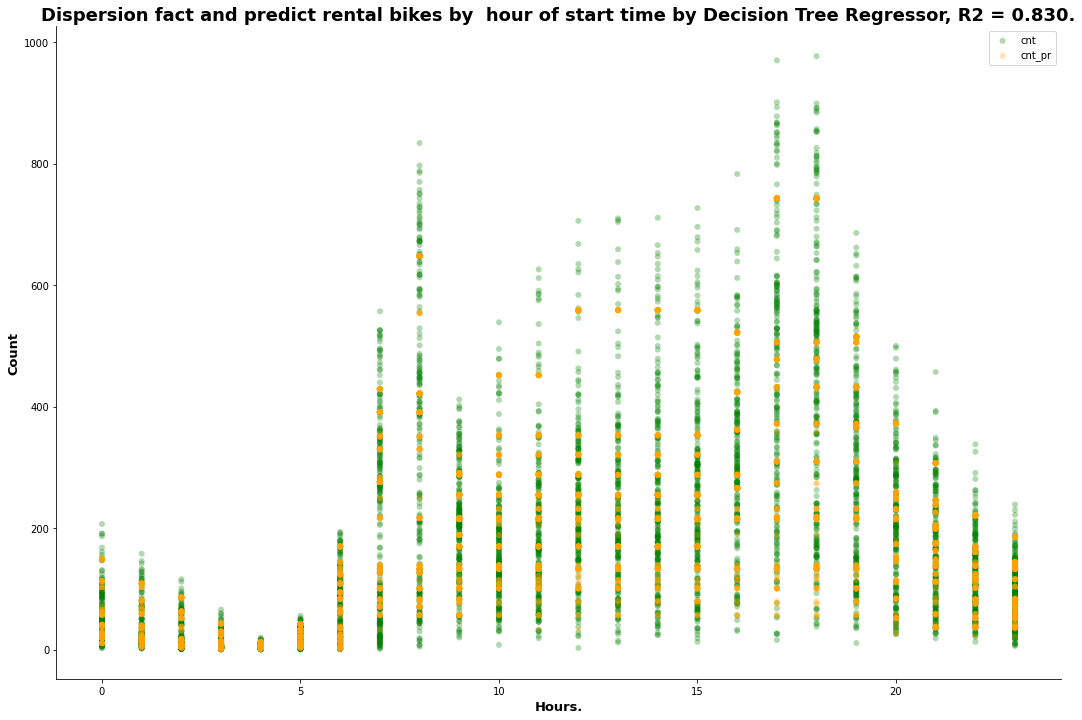

In [ ]:
fig, ax = plt.subplots(figsize=(18, 12))
bikes = ["cnt","cnt_pr"]
for i, color in enumerate(['green', 'orange' ]):
    ax.scatter(bike_predict.hr, bike_predict[bikes[i]] , 
               c=color, label=bikes[i], alpha=0.3, edgecolors='none')
ax.set_title("Dispersion fact and predict rental bikes by  hour of start time \
by Decision Tree Regressor, R2 = {:.3f}.".format(r2_pr),
             fontsize = 18, fontweight = "bold")
ax.set_xlabel("Hours.", fontsize = 13, 
              fontweight = "bold")
ax.set_ylabel("Count", fontsize = 13, 
              fontweight = "bold")
ax.legend()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.show()

## 6. Apply Decision Random Forest

Finding hyper parameters for Decision Random Forest.

In [ ]:
rfr = RandomForestRegressor()

print("Hyper parameters list:\n")
pprint(rfr.get_params())

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 39)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfr = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_stats = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
                              n_iter = 10, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=3,
                              return_train_score=True)

rfr_stats.fit(X_ss_all, Y_ss_all.values.ravel());

best_params = rfr_stats.best_params_;

Hyper parameters list:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
pprint(best_params)

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500}


### Evaluate default model

In [ ]:
# Create instance woth  default parameters 
rfr_def = RandomForestRegressor(random_state = 42)

# Create df for metrics
rfr_def_metr = pd.DataFrame()
rfr_def_metr["scores"] = ["mae", "rmse", "r2"]

# Split df
X_ss, x_ss, Y_ss, y_ss = train_test_split(X_ss_all, Y_ss_all, 
                                          test_size= 0.3, random_state=42)
rfr_def.fit(X_ss, Y_ss.values.ravel())

# Calculate scoring for predict x
y_ss_pr =rfr_def.predict(x_ss) 
mae_pr = mean_absolute_error(y_ss, y_ss_pr)
rmse_pr = mean_squared_error(y_ss, y_ss_pr, squared=False)
r2_pr = r2_score(y_ss, y_ss_pr)
rfr_def_metr["y_pred_def"] = [mae_pr, rmse_pr, r2_pr]

# Calculate scoring for predict  X 
Y_ss_pr =rfr_def.predict(X_ss)
mae_pr_Y = mean_absolute_error(Y_ss, Y_ss_pr)
rmse_pr_Y = mean_squared_error(Y_ss, Y_ss_pr, squared=False)
r2_pr_Y = r2_score(Y_ss, Y_ss_pr)
rfr_def_metr["Y_pred_def"] = [mae_pr_Y, rmse_pr_Y, r2_pr_Y]
rfr_def_metr["diff_y-Y"] = rfr_def_metr["y_pred_def"]  \
                        - rfr_def_metr["Y_pred_def"]
display(rfr_def_metr);

,scores,y_pred_def,Y_pred_def,diff_y-Y
0,mae,0.140242,0.053969,0.086273
1,rmse,0.233429,0.090852,0.142577
2,r2,0.943254,0.991882,-0.048628


### Evaluate model with best parameters

In [ ]:
# Create instance with best parameters 
rfr_best = RandomForestRegressor(n_estimators = 550, min_samples_split = 2,
                                 min_samples_leaf = 1, max_features = 'auto',
                                 max_depth = 100, bootstrap = True)

# Create df for metrics
rfr_best_metr = pd.DataFrame()
rfr_best_metr["scores"] = ["mae", "rmse", "r2"]

# Split df
X_ss, x_ss, Y_ss, y_ss = train_test_split(X_ss_all, Y_ss_all, 
                                          test_size= 0.3, random_state=42)
rfr_best.fit(X_ss, Y_ss.values.ravel())

# Calculate scoring for predict x
y_ss_pr_rfr =rfr_best.predict(x_ss) 
mae_pr_rfr = mean_absolute_error(y_ss, y_ss_pr_rfr)
rmse_pr_rfr = mean_squared_error(y_ss, y_ss_pr_rfr, squared=False)
r2_pr_rfr = r2_score(y_ss, y_ss_pr_rfr)
rfr_best_metr["y_pred_best_rfr"] = [mae_pr_rfr, rmse_pr_rfr, r2_pr_rfr]

# Calculate scoring for predict  X 
Y_ss_pr_rfr =rfr_best.predict(X_ss)
mae_pr_Y_rfr = mean_absolute_error(Y_ss, Y_ss_pr_rfr)
rmse_pr_Y_rfr = mean_squared_error(Y_ss, Y_ss_pr_rfr, squared=False)
r2_pr_Y_rfr = r2_score(Y_ss, Y_ss_pr_rfr)
rfr_best_metr["Y_pred_best_rfr"] = [mae_pr_Y_rfr, rmse_pr_Y_rfr, r2_pr_Y_rfr]
rfr_best_metr["diff_y-Y"] = rfr_best_metr["y_pred_best_rfr"]  \
                        - rfr_best_metr["Y_pred_best_rfr"]
display(rfr_best_metr);

,scores,y_pred_best_rfr,Y_pred_best_rfr,diff_y-Y
0,mae,0.138969,0.053114,0.085855
1,rmse,0.232347,0.088557,0.143790
2,r2,0.943778,0.992287,-0.048508


As seen above difference between values R2 for the best and default parameters is equal 0.06%.

Decode back values for all x and fact and predicted y and display values for fact cnt and predicted cnt

In [ ]:
x_rfr = x_ss.copy()
x_rfr.iloc[:,:] = ss_x_all.inverse_transform(x_rfr.iloc[:,:]) 

y_pr_rfr = np.copy(y_ss_pr_rfr)
y_pr_rfr = ss_y_all.inverse_transform(y_pr_rfr)

y_rfr = y_ss.copy()
y_rfr.iloc[:,[0]] = ss_y_all.inverse_transform(y_rfr.iloc[:,[0]])

# Create df for x and y and y predict
bike_predict_rfr = x.copy()
bike_predict_rfr["cnt"] = y_rfr
bike_predict_rfr["cnt_pr"] = np.around(y_pr_rfr)
display(bike_predict_rfr.iloc[:,-3:].head(15))

,windspeed,cnt,cnt_pr
12830,0.1940,425.0,360.0
8688,0.2239,88.0,98.0
7091,0.2836,4.0,11.0
12230,0.3582,526.0,536.0
431,0.3881,13.0,14.0
1086,0.2836,32.0,37.0
11605,0.1343,706.0,742.0
7983,0.0000,26.0,40.0
10391,0.1940,2.0,9.0
7046,0.2239,21.0,26.0


As seen above despite the higher values R2 some outliers remain.

Plot scatter number of rented bikes by hour for fact and predict values of cnt.

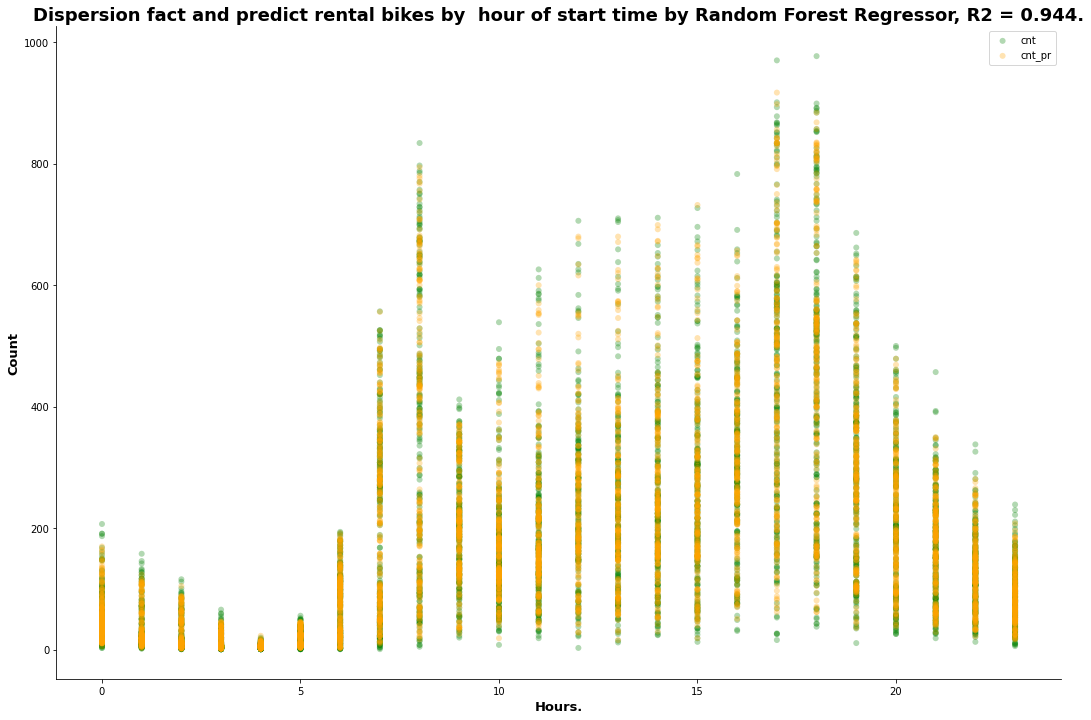

In [ ]:
fig, ax = plt.subplots(figsize=(18, 12))
bikes = ["cnt", "cnt_pr" ]
for i, color in enumerate(['green', 'orange' ]):
    ax.scatter(bike_predict_rfr.hr, bike_predict_rfr[bikes[i]] , 
               c=color, label=bikes[i], alpha=0.3, edgecolors='none')
ax.set_title("Dispersion fact and predict rental bikes by  hour of start time \
by Random Forest Regressor, R2 = {:.3f}.".format(r2_pr_rfr),
             fontsize = 18, fontweight = "bold")
ax.set_xlabel("Hours.", fontsize = 13, 
              fontweight = "bold")
ax.set_ylabel("Count", fontsize = 13, 
              fontweight = "bold")
ax.legend()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.show()

## 7. Conclusion

* The Random Forest Regressor and  Decision Tree Regressor showed higher prediction accuracy than standard OLS linear regression.


* The accuracy of the prediction Random Forest Regressor  at the values of the default parameters and the hyperparameters obtained as a result of cross validation requires further investigation.


* After standard OLS linear regression the Decision Tree Regressor it gives the impression of a silver bullet, but only practice will give the answer whether it is True or False.
 

Created on August 18, 2021

@author: Vadim Maklakov, used some ideas from public Internet resources.

© 3-clause BSD License

Software environment: Debian 10, Python 3.8.7

See required installed and imported python modules in the cell No 1.